# Part 2 - Model Training

Here we'll use the data generated in the previous notebook to train our neural network to play Minesweeper.

In [19]:
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import torch
from ais import PytorchsweeperAI
from IPython import display
from torch import nn
from torch.utils.data import DataLoader, Dataset
from utils import get_device, test_win_rates

In [2]:
device = get_device()

Using cuda device


We can create a simple PyTorch `Dataset` class for our training data, which will load the `.npz` files saved in the last notebook and provide the required interfaces to read from them.

In [3]:
class MinesweeperDataset(Dataset):
    def __init__(self, dataset_file):
        data = np.load(dataset_file)
        self.input_data = data["input_data"]
        self.output_data = data["output_data"]

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx: int):
        return self.input_data[idx], self.output_data[idx]

In [4]:
training_data = MinesweeperDataset("training_data.npz")
test_data = MinesweeperDataset("testing_data.npz")

In [5]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

For the Pytorchsweeper neural network, we'll use a series of convolutional layers with 3x3 kernels. Minesweeper maps well to convolutional neural networks, as the likelihood that a given square contains a bomb is directly related to the information provided by adjacent squares. Each convolutional layer expands the receptive field and allows the network to solve more complex arrangements of bombs.

To allow us to easily experiment with different network configurations, we define the network itself as configurable. There are two parameters, `inner_layers` and `channels`. There is an input layer with one input channel taking in our gamestate, then a number of layers defined by `inner_layers`, followed by an output layer with one output channel. The number of channels between each layer is set by `channels`, and is constant through the model.

Our goal for the network is to generate an output array that's as close as possible to the output data we generated with our training set. This can be thought of as a confidence map, where cells which the network is very confident are good guesses have high values close to 1, and cells which the network is confident aren't good guesses will have low values, close to 0.

In [6]:
class PytorchsweeperNeuralNet(nn.Module):
    def __init__(self, inner_layers: int, channels: int):
        super().__init__()
        self.inner_layers = inner_layers
        self.channels = channels

        layer_dict = OrderedDict({
            "input_conv": nn.Conv2d(1, self.channels, 3, padding='same'),
            "input_relu": nn.ReLU()
        })

        for n in range(self.inner_layers):
            layer_dict["inner_conv_{}".format(n+1)] = nn.Conv2d(self.channels, self.channels, 3, padding='same')
            layer_dict["inner_relu_{}".format(n+1)] = nn.ReLU()

        layer_dict["output_conv"] = nn.Conv2d(self.channels, 1, 3, padding='same')
        layer_dict["output_relu"] = nn.ReLU()
        
        self.convolutional_relu_stack = nn.Sequential(layer_dict)

    def forward(self, x):
        return self.convolutional_relu_stack(x)

A network with 8 inner layers and 16 channels works well, so we'll build a model with those settings.

In [7]:
inner_layers = 8
channels = 16

model = PytorchsweeperNeuralNet(inner_layers, channels).to(device)

We can see how many trainable parameters are in our model.

In [8]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

18865

The loss function we'll be using is mean squared error, and we'll use Adam as the optimizer.

In [9]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

We train the network using the standard approach. We use 20 epochs here, although longer training could achieve better results (particularly if configuring the network with more layers and/or channels).

In [10]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

In [11]:
def test(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    return test_loss

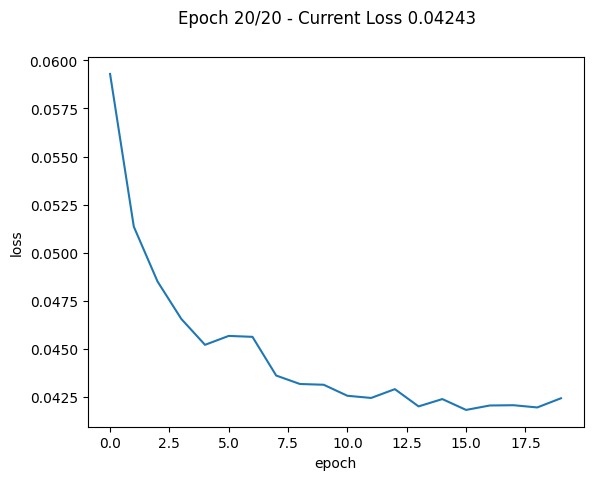

In [12]:
epochs = 20
loss_dict = {}

for t in range(epochs):
    train(train_dataloader, model, loss_fn, optimizer)
    test_loss = test(test_dataloader, model, loss_fn)

    # Update graph
    loss_dict[t+1] = test_loss
    plt.plot(loss_dict.values())
    plt.suptitle("Epoch {}/{} - Current Loss {:.4}".format(t+1, epochs, test_loss))
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()
    if t != epochs-1:
        display.clear_output(wait=True)

To validate the model we can look at the loss above, but to get more tangible results we can actually have it play games of Minesweeper and see how it does.

Here we'll use a class called `PytorchsweeperAI`, defined in `ais.py`, which is a simple wrapper for the PyTorch model. It takes the state of the game, feeds it into the model, and returns the model's prediction.

In [21]:
pytorchsweeper_ai = PytorchsweeperAI(model, device)

The `test_win_rates` function, from `utils.py` runs a number of games at different difficulties to get win rates at each difficulty.

Note that we shouldn't expect even a perfect model to win every game. There are circumstances where the player doesn't have enough information to be certain on what the right move is and has to guess, and these are more common in higher difficulties. Even an optimal approach will only win on Expert mode around 40% of the time.

In [23]:
test_win_rates(pytorchsweeper_ai, iterations=100)

Win rate on Beginner: 96.00%
Win rate on Intermediate: 90.00%
Win rate on Expert: 37.00%


We can then save the model as a TorchScript file, so we can reload it later.

In [15]:
torchscript_model = torch.jit.script(model)
torchscript_model.save('pytorchsweeper_model.pt')

We can also load other models. Here we've got a larger model (with 16 internal layers) trained over a larger number of epochs.

In [16]:
model = torch.jit.load('prepared_pytorchsweeper_model.pt').to(device)
advanced_pytorchsweeper_ai = PytorchsweeperAI(model, device)

In [18]:
test_win_rates(advanced_pytorchsweeper_ai, iterations=100)

Win rate on Beginner: 93.00%
Win rate on Intermediate: 90.00%
Win rate on Expert: 41.00%


In the next notebook, we'll run through games with the model step-by-step, looking at the output of the model to represent how it sees the game.